In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import copy
import select
from skimage import feature as ft

from sklearn.utils import shuffle


importpath   = "../../../Dataset/"
testrainpath = ["Testing", "Training"]
namespath    = ["/Abed/", "/Daniel/", "/Jules/", "/Lea/", "/Patrick/"]
rescaledpath = "Rescaled"
croppedpath  = "Cropped"

meta_data = {0: 'Abed', 1: 'Daniel', 2: 'Jules', 3: 'Lea', 4: 'Patrick'}

def get_data(isCropped=True):

    # Test train data
    X_train = []
    Y_train = []

    X_test  = []
    Y_test  = []

    # define both import paths
    testpath = importpath+testrainpath[0]
    trainpath= importpath+testrainpath[1]

    for i, npath in enumerate(namespath):

        if isCropped:
            testfolder = testpath + croppedpath + npath
            trainfolder= trainpath+ croppedpath + npath
        else:
            testfolder = testpath + rescaledpath + npath
            trainfolder= trainpath+ rescaledpath + npath

        for imgname in os.listdir(testfolder):

            img = cv2.imread(testfolder+imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_test.append(img)
            Y_test.append(i)

        for imgname2 in os.listdir(trainfolder):

            img = cv2.imread(trainfolder+imgname2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_train.append(img)
            Y_train.append(i)

#     # once the data is saved, shuffle it
#     X_train , Y_train = shuffle(X_train, Y_train)
#     X_test  , Y_test  = shuffle(X_test, Y_test)

    return np.asarray(X_train), np.asarray(Y_train), np.asarray(X_test), np.asarray(Y_test), meta_data

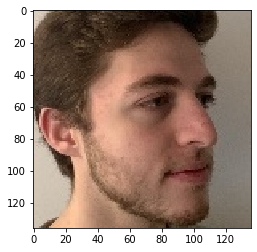

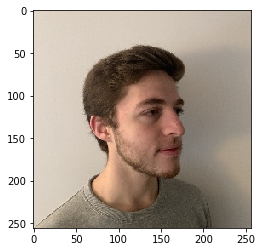

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
import matplotlib.pyplot as plt


def sift(img):

    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)
    
    p = []
    keypoints3, descriptors = sift.compute(img, keypoints)
    for k in keypoints3:
        p.append(k.pt)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#     display
    plt.figure(figsize=(10, 10))
    plt.subplot(121), plt.imshow(img)
    plt.title("Input Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_disp)
    plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
    plt.show()

    # num of SIFT keypoints
    print('Num keypoints: ' + str(len(keypoints)))

    return p


import cv2
# Get croppped image coordinates in original image (x,y in top left corner)
def get_coordinates(img_rescaled, img_cropped):
    # imgggg_rgb = cv2.imread("../../../Dataset/TrainingRescaled/Abed/scale1_0.jpeg")
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # template = cv2.imread("../../../Dataset/TrainingCropped/Abed/scale1_0.jpeg", 0)
    img_rescaled = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    w, h = img_cropped.shape[::-1]
    res = cv2.matchTemplate(img_rescaled, img_cropped, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = top_left[0]
    y = top_left[1]
    return x, y


def make_patch(img,img_cropped, size, k):
    # get patch centers
    patch_centers = []
    for i in k:
        patch_centers.append(i)

    # extract patches
    patch_images = []
    patch_size = size
    count=0
    for center in patch_centers:
        patchXStart = int(center[0] - (patch_size / 2.))
        patchYStart = int(center[1] - (patch_size / 2.))
        if((center[0] + patch_size)>img_cropped.shape[1] or (center[0] - patch_size)<0 or (center[1] + patch_size)>img_cropped.shape[0] or (center[1] - patch_size)<0 ):
            count+=1
            x,y = get_coordinates(img, img_cropped)
            patchXStart += x
            patchYStart += y
            patch_images.append(img[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])
        else:
            patch_images.append(img_cropped[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])

    print("count= " , count)
    # display
    for im in patch_images:
        plt.figure(figsize=(5, 5))
        plt.imshow(im)
        plt.title("Input Image"), plt.xticks([]), plt.yticks([])
        plt.show()
    return patch_images


# ----- HoG Function ----- #
def rgb2gray(im):
    gray = im[:, :, 0] * 0.2989 + im[:, :, 1] * 0.5870 + im[:, :, 2] * 0.1140
    return gray

def hog_features(imgs, cells):
    train_x = []
    for data in imgs:
        gray = rgb2gray(data) / 255.0
        x = ft.hog(gray, orientations=9, pixels_per_cell=(2, 2),
                   cells_per_block=(cells, cells))
        train_x.append(x)
    return train_x



if __name__ == '__main__':

   # Read in data
    cropped_data = get_data(isCropped=True)
    X_train_cropped = cropped_data[0]
    Y_train_cropped = cropped_data[1]
    X_test_croppped = cropped_data[2]
    Y_test_cropped = cropped_data[3]
    metadata_cropped = cropped_data[4]
    
    data = get_data(isCropped=False)
    X_train = data[0]
    Y_train = data[1]
    X_test = data[2]
    Y_test = data[3]
    metadata = data[4]

    plt.imshow(X_train_cropped[0])
    plt.show()
    

    plt.imshow(X_train[0]) 
    plt.show()




3.4.2


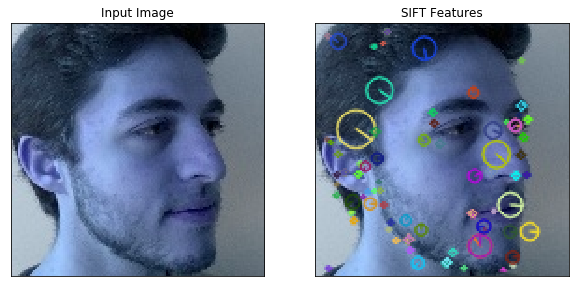

Num keypoints: 86


In [18]:
cropped_img = X_train_cropped[0]
original_img = X_train[0]

print(cv2.__version__)

kp = sift(cropped_img)



count=  26


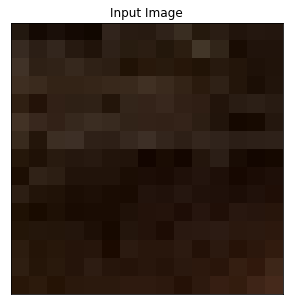

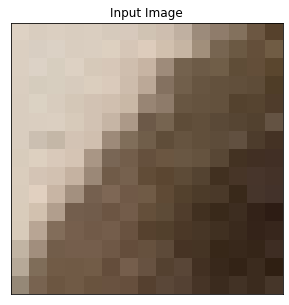

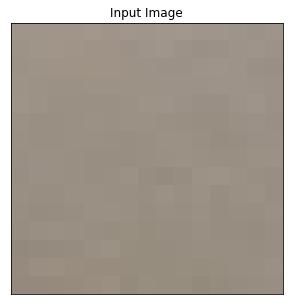

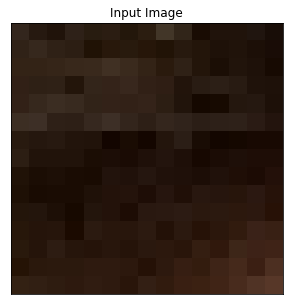

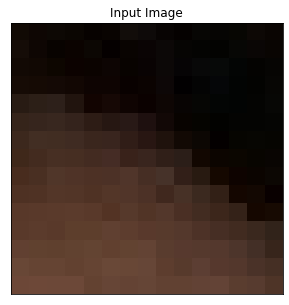

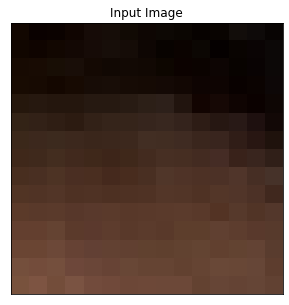

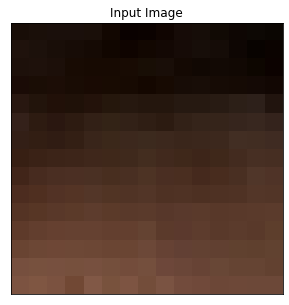

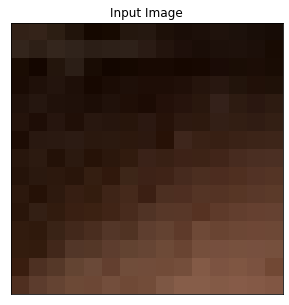

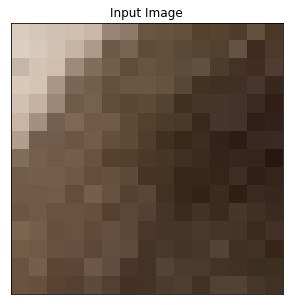

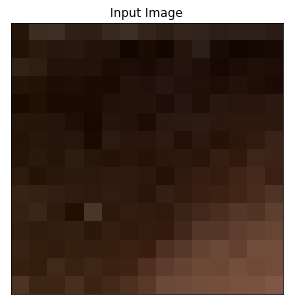

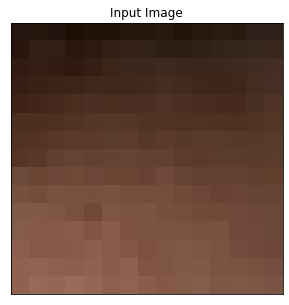

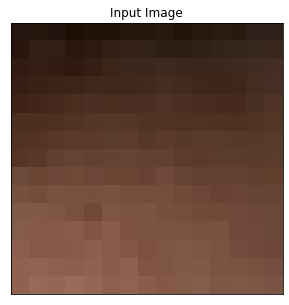

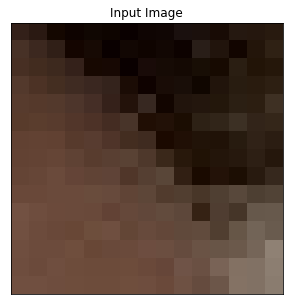

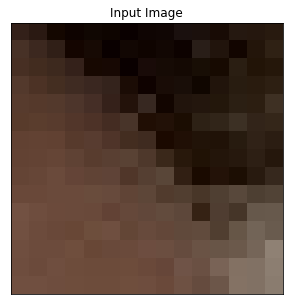

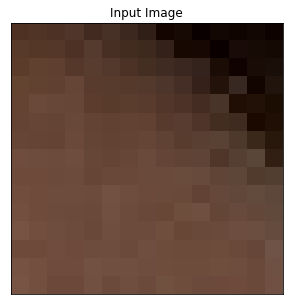

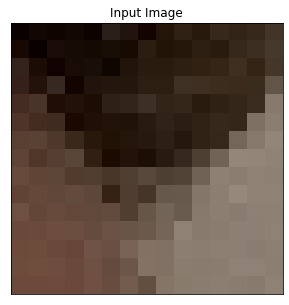

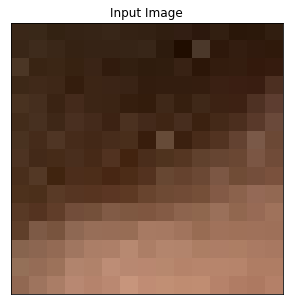

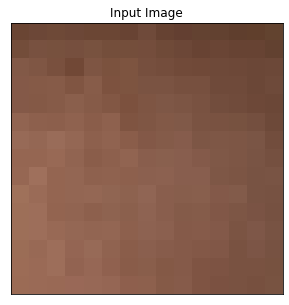

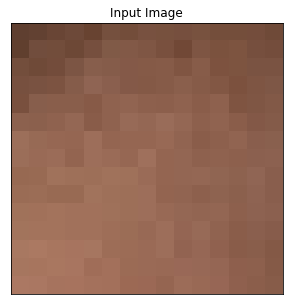

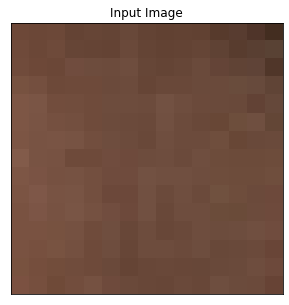

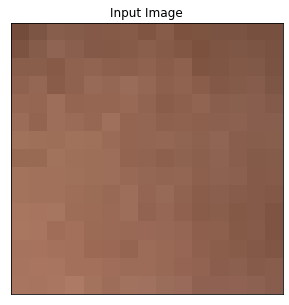

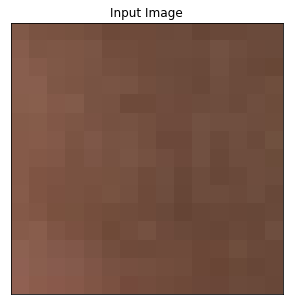

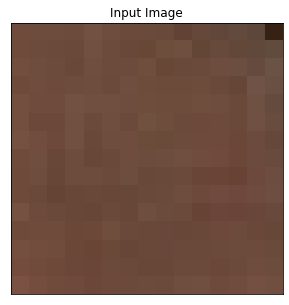

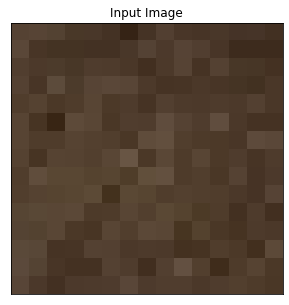

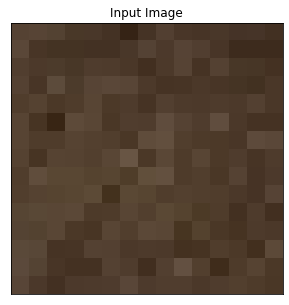

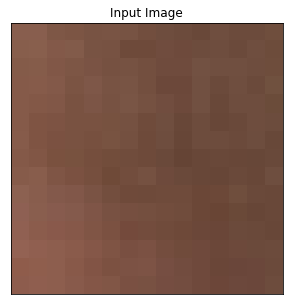

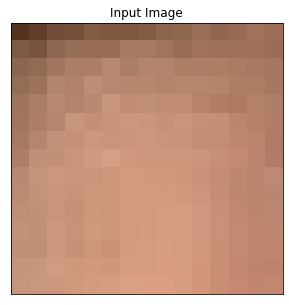

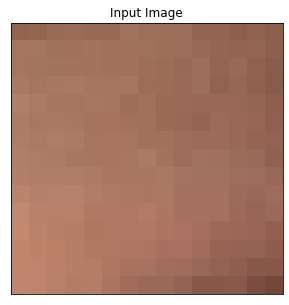

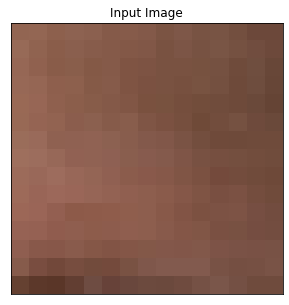

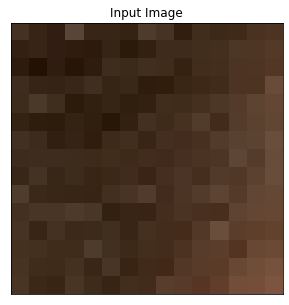

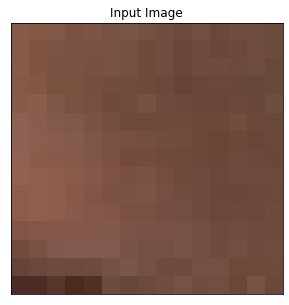

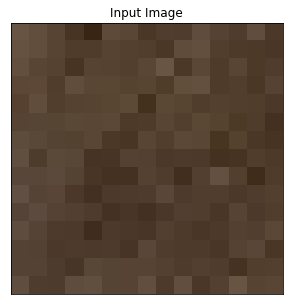

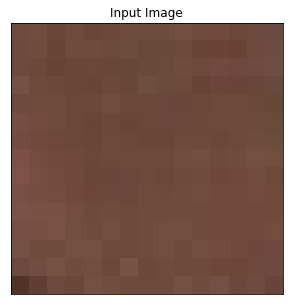

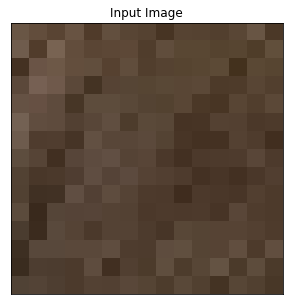

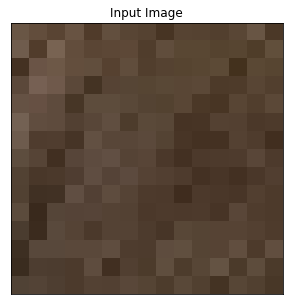

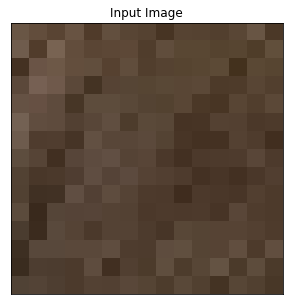

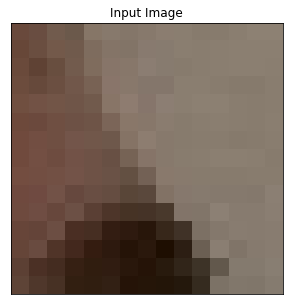

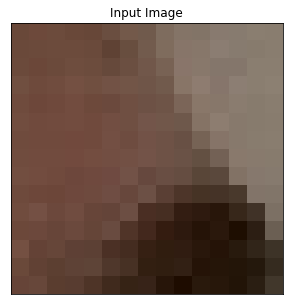

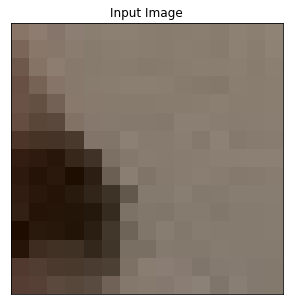

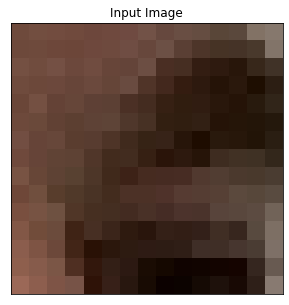

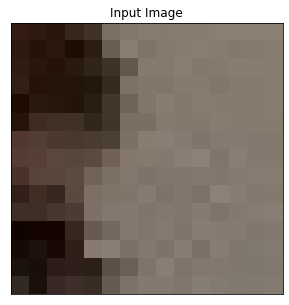

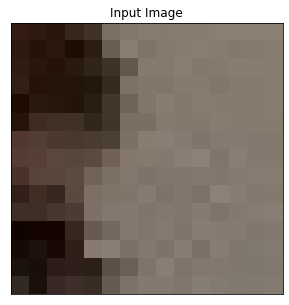

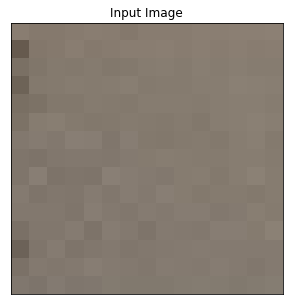

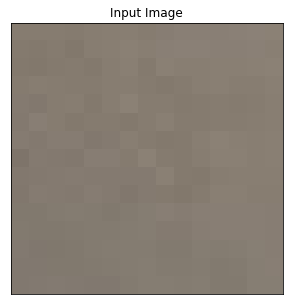

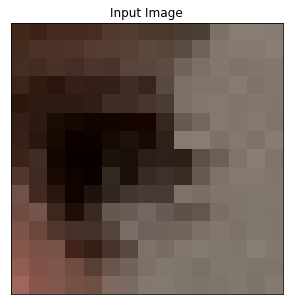

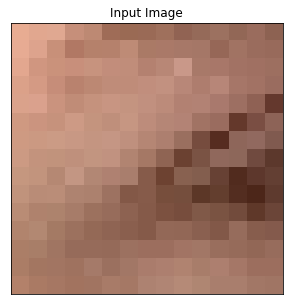

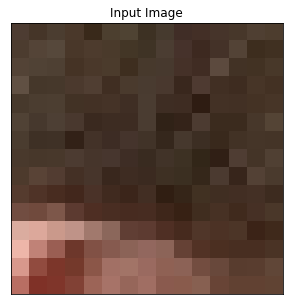

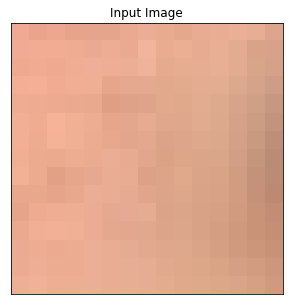

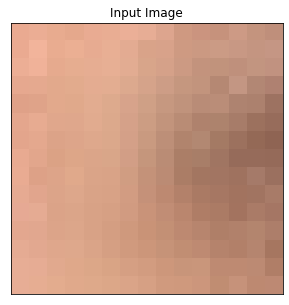

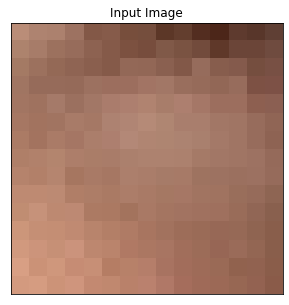

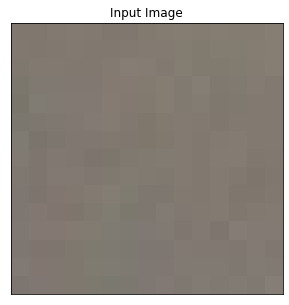

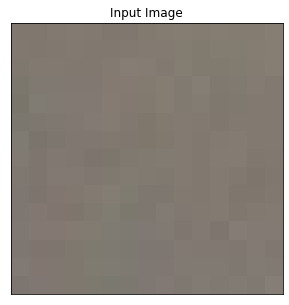

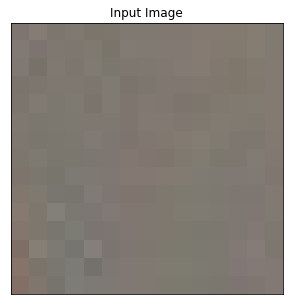

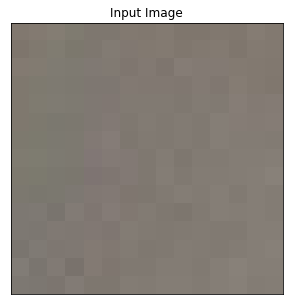

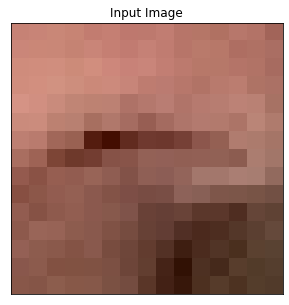

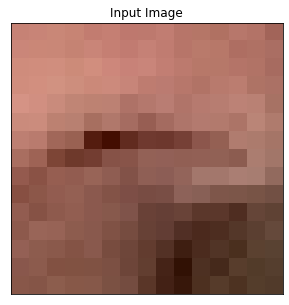

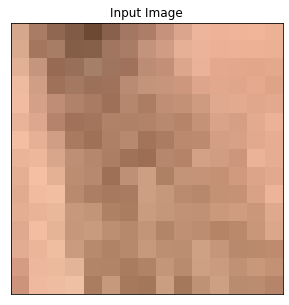

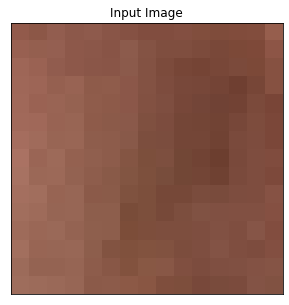

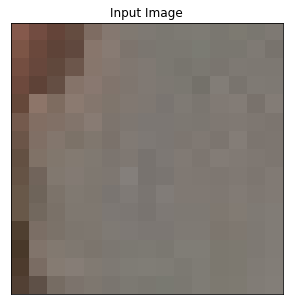

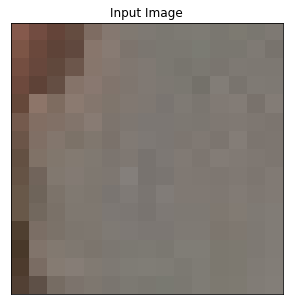

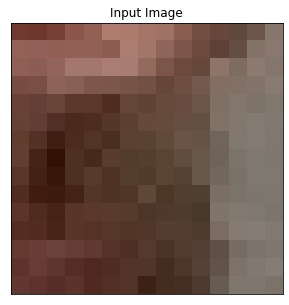

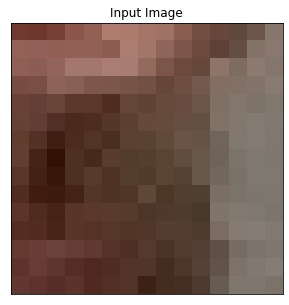

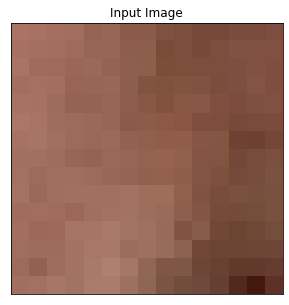

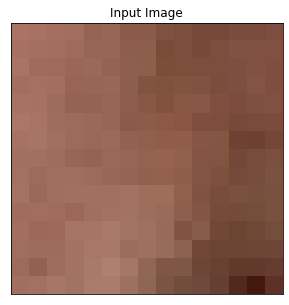

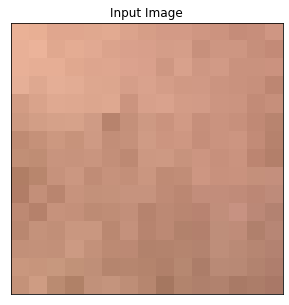

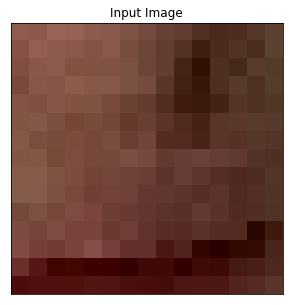

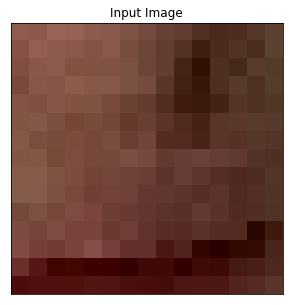

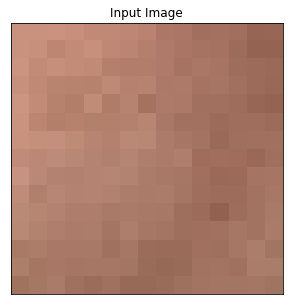

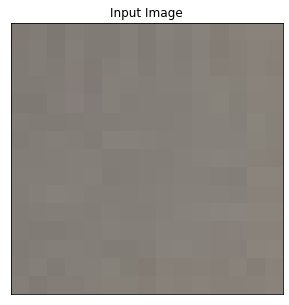

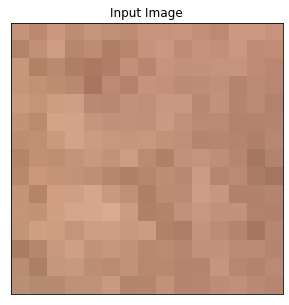

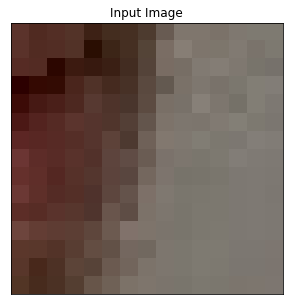

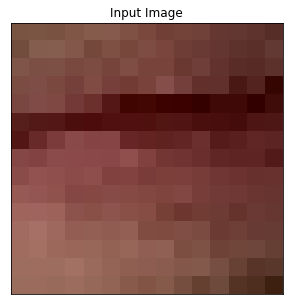

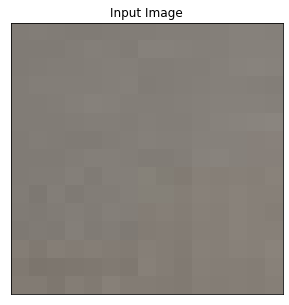

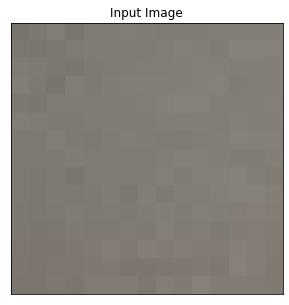

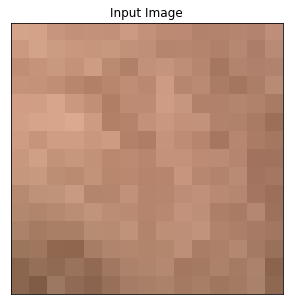

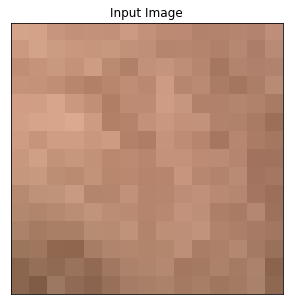

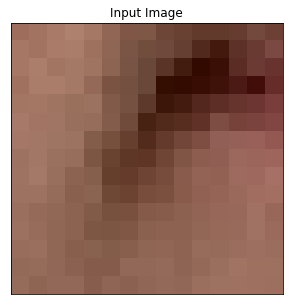

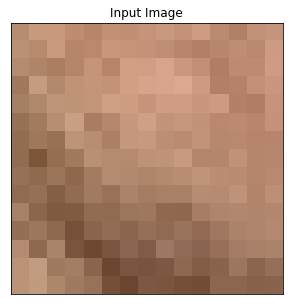

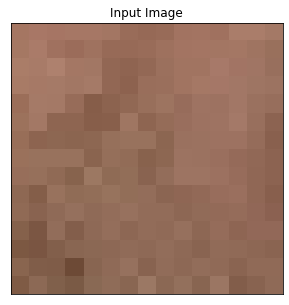

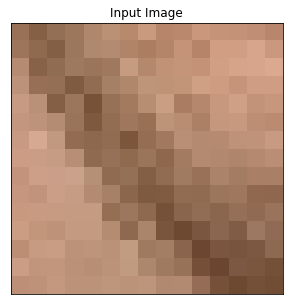

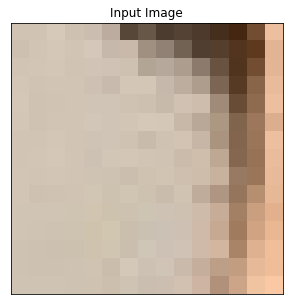

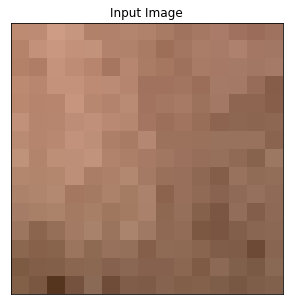

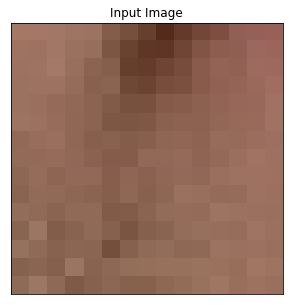

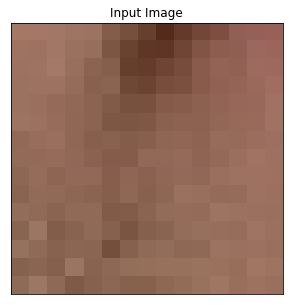

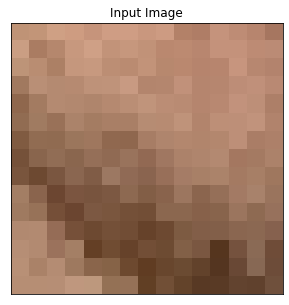

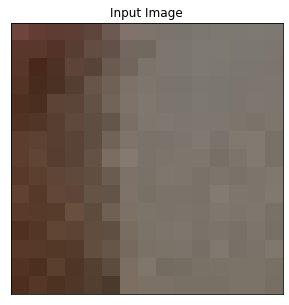

In [19]:
patches = make_patch(img=original_img,img_cropped=cropped_img, size=15, k=kp)

In [32]:
'''
Extract HoG descriptor for the patch as follows.
Fix the block size= 2, number of bins = 9 and vary the cell size. 
Use cell sizes 3 × 3, 4 × 4 and 5 × 5 . 
Build separate vocabularies for HoG descriptor with different cell sizes. 
Test and evaluate the vocabularies using recognition rate. 
Plot recognition rate (on y-axis) vs cell size of the HoG descriptor (on x-axis). 
Compute confusion matrix for the best performing vocabulary.
'''
hog_3 =  hog_features(patches, 3)
hog_4 =  hog_features(patches, 4)
hog_5 =  hog_features(patches, 5)
